# ColorSkim Machine Learning AI



In [76]:
# import modul
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb as wb
from wandb.keras import WandbCallback
from rahasia import API_KEY_WANDB # type: ignore
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [2]:
# cek ketersediaan GPU untuk modeling
# NVidia GeForce MX250 - office
# NVidia GeForce GTX1060 - home
device_lib.list_local_devices()[1]

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1408103015
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2884827362631592935
physical_device_desc: "device: 0, name: NVIDIA GeForce MX250, pci bus id: 0000:02:00.0, compute capability: 6.1"
xla_global_id: 416903419

## Variabel Global

In [17]:
DIR_MODEL_CHECKPOINT = 'colorskim_checkpoint'
# kita akan mengatur toleransi_es sebagai fraksi (fraksi_toleransi) tertentu dari jumlah total epoch
# dan toleransi_rlop sebagai toleransi_es dibagi dengan jumlah kesempatan (kesempatan_rlop)
# dilakukannya reduksi pada learning_rate 
EPOCHS = 1000
FRAKSI_TOLERANSI = 0.2
KESEMPATAN_RLOP = 4
TOLERANSI_ES = int(EPOCHS*FRAKSI_TOLERANSI)
TOLERANSI_RLOP = int(TOLERANSI_ES/KESEMPATAN_RLOP)
FRAKSI_REDUKSI_LR = 0.1
RANDOM_STATE = 11
RASIO_TEST_TRAIN = 0.2


## Callbacks

Beberapa *callbacks* yang akan digunakan dalam proses *training* model diantaranya:
* `WandbCallback` - *Callback* ke [wandb.ai](https://wandb.ai) untuk mencatat log dari sesi *training* model.
* `ModelCheckpoint` - Untuk menyimpan model dengan *val_loss* terbaik dari seluruh *epoch* dalam *training* model.
* `EarlyStopping` (ES) - *Callback* ini digunakan untuk menghentikan proses *training* model jika selama beberapa *epoch* model tidak mengalami perbaikan pada metrik *val_loss*-nya. *Callback* ini juga digunakan bersama dengan `ReduceLROnPlateau` dimana *patience* ES > *patience* RLOP.
* `ReduceLROnPlateau` (RLOP) - *Callback* ini digunakan untuk memperkecil *learning_rate* dari model jika tidak mengalami perbaikan *val_loss* selama beberapa *epoch*.

*Patience* dari ES di-set lebih tinggi dari *patience* RLOP untuk memberikan kesempatan bagi RLOP untuk memperkecil *learning_rate* beberapa kali sebelum proses *training* model dihentikan oleh ES setelah tidak berhasil mendapatkan *val_loss* yang lebih baik selama beberapa *epoch*.

In [15]:
# login ke wandb
wb.login(key=API_KEY_WANDB)

# Pembuatan fungsi callback
def wandb_callback():
    return WandbCallback(save_model=False, # model akan disimpan menggunakan callback ModelCheckpoint
                         log_weights=True, # weight akan disimpan untuk visualisasi di wandb
                         log_gradients=True) # gradient akan disimpan untuk visualisasi di wandb
def model_checkpoint(nama_model):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(DIR_MODEL_CHECKPOINT, nama_model),
                                              verbose=0,
                                              save_best_only=True) # model dengan 'val_loss' terbaik akan disimpan
def early_stopping():
    return tf.keras.callbacks.EarlyStopping(patience=TOLERANSI_ES)
def reduce_lr_on_plateau():
    return tf.keras.callbacks.ReduceLROnPlateau(factor=FRAKSI_REDUKSI_LR, # pengurangan learning_rate diset sebesar 0.1 * learning_rate
                                                patience=TOLERANSI_RLOP, #
                                                verbose=0)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jpao (pri-data). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\jPao/.netrc


## Data

Data yang dipergunakan adalah sebanyak 101,077 kata. Terdapat 2 versi data, data versi 1 hanya memiliki 56,751 kata dan data versi 2 adalah data lengkap.
* Data 1: 56,751 kata, terdiri dari 34,174 kata dengan label `bukan_warna` dan 22,577 kata dengan label `warna` atau rasio 1.51 : 1 `bukan_warna` berbanding `warna`
* Data 2: 101,077 kata, rincian menyusul....

`brand`, `urut_kata` dan `total_kata` akan digunakan sebagai alternatif variabel independen tambahan dalam model tertentu.

In [72]:
# Membaca data ke dalam DataFrame pandas
data = pd.read_csv('data/setengah_dataset_artikel.csv')
data[:10]

,brand,nama_artikel,kata,label,urut_kata,total_kata
0,ADI,ADISSAGE-BLACK/BLACK/RUNWHT,ADISSAGE,bukan_warna,1,4
1,ADI,ADISSAGE-BLACK/BLACK/RUNWHT,BLACK,warna,2,4
2,ADI,ADISSAGE-BLACK/BLACK/RUNWHT,BLACK,warna,3,4
3,ADI,ADISSAGE-BLACK/BLACK/RUNWHT,RUNWHT,warna,4,4
4,ADI,ADISSAGE-N.NAVY/N.NAVY/RUNWHT,ADISSAGE,bukan_warna,1,4
5,ADI,ADISSAGE-N.NAVY/N.NAVY/RUNWHT,N.NAVY,warna,2,4
6,ADI,ADISSAGE-N.NAVY/N.NAVY/RUNWHT,N.NAVY,warna,3,4
7,ADI,ADISSAGE-N.NAVY/N.NAVY/RUNWHT,RUNWHT,warna,4,4
8,ADI,3 STRIPE D 29.5-BASKETBALL NATURAL,3,bukan_warna,1,6
9,ADI,3 STRIPE D 29.5-BASKETBALL NATURAL,STRIPE,bukan_warna,2,6


### Eksplorasi Data

In [6]:
# distribusi label dalam data
data['label'].value_counts()

bukan_warna    34174
warna          22577
Name: label, dtype: int64

In [73]:
# distribusi label dalam brand (data hanya menunjukkan 10 teratas)
data[['brand', 'label']].value_counts().unstack().sort_values(by='bukan_warna', ascending=False)[:10]

label,bukan_warna,warna
brand,,
NIK,13396.0,10807.0
ADI,10028.0,7073.0
PUM,4279.0,2062.0
BBC,1174.0,367.0
CAO,887.0,61.0
HER,868.0,287.0
AGL,611.0,212.0
KIP,554.0,321.0
STN,494.0,255.0


### Konversi Data ke dalam Train dan Test

Data akan dibagi ke dalam train dan test data menggunakan metode `train_test_split` dari modul *sklearn.model_selection* dengan menggunakan rasio dan keacakan yang telah ditentukan di variabel global (lihat *RASIO_TEST_TRAIN* dan *RANDOM_STATE*).

In [77]:
train_kata, test_kata, train_label, test_label = train_test_split(data['kata'].to_numpy(), 
                                                                  data['label'].to_numpy(), 
                                                                  test_size=RASIO_TEST_TRAIN,
                                                                  random_state=RANDOM_STATE)

In [81]:
# Eksplorasi contoh hasil split train dan test
train_label_unik, train_label_hitung = np.unique(train_label, return_counts=True)
test_label_unik, test_label_hitung = np.unique(test_label, return_counts=True)
print(f'5 kata pertama di train_data:\n{train_kata[:5]}\n') 
print(f'5 label pertama di train_label:\n{train_label[:5]}\n') 
print(f'5 kata pertama di test_data:\n{test_kata[:5]}\n')
print(f'5 label pertama di test_label:\n{test_label[:5]}\n')
train_label_distribusi = np.column_stack((train_label_unik, train_label_hitung))
test_label_distribusi = np.column_stack((test_label_unik, test_label_hitung))
print(f'Distribusi label di train: \n{train_label_distribusi}\n')
print(f'Distribusi label di test: \n{test_label_distribusi}')

5 kata pertama di train_data:
['GREY' 'BLACK' 'U' 'ANTHEM' 'UTIBLK']

5 label pertama di train_label:
['warna' 'warna' 'bukan_warna' 'bukan_warna' 'warna']

5 kata pertama di test_data:
['SESOYE' 'GHOST' 'BLACK' 'FLEX' 'BLACK']

5 label pertama di test_label:
['warna' 'bukan_warna' 'warna' 'bukan_warna' 'warna']

Distribusi label di train: 
[['bukan_warna' 27355]
 ['warna' 18045]]

Distribusi label di test: 
[['bukan_warna' 6819]
 ['warna' 4532]]


### Konversi label ke dalam numerik

Kita akan melakukan pengkonversian data label ke dalam bentuk numerik, dikarenakan jaringan saraf buatan hanya dapat bekerja dalam data numerik. 

Data label diubah dalam format numerik menggunakan metode `LabelEncoder` dari modul *sklearn.preprocessing*. 

Alternatif lainnya adalah menggunakan OneHotEncoder dimana data label akan ditranslasi menjadi jumlah kolom sesuai dengan jumlah output dan output tertentu akan memiliki nilai 1 pada kolom nilai yang menjadi sasaran.
Contoh:
* LabelEncoder akan merubah `bukan_warna` dan `warna` menjadi 1 dan 0
* OneHotEncoder akan merubah `bukan_warna` dan `warna` menjadi [1, 0] dan [0, 1]

Tergantung kasus dan loss function yang akan digunakan, pada kasus multiclass classification, pelabelan dalam bentuk LabelEncoder atau lebih dikenal dengan istilah sparse_category akan menggunakan loss function `SparseCategoricalCrossEntropy` sedangkan pelabelan dalam bentuk `OneHotEncoder` membutuhkan loss function `CategoricalCrossEntropy` atau dalam kasus Binomial Classification akan menggunakan loss function `BinaryCrossEntropy`. 

Dimana dalam kasus ini dikarenakan hanya terdapat dua kemungkinan output yang akan diprediksi dan dinilai akurasinya, maka kita akan menggunakan `LabelEncoder` dan `BinaryCrossEntropy` untuk loss function-nya.

In [82]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_label_encode = label_encoder.fit_transform(train_label)
test_label_encode = label_encoder.transform(test_label)
train_label_encode[:5], test_label_encode[:5]

(array([1, 1, 0, 0, 1]), array([1, 0, 1, 0, 1]))

## Model 0: model dasar

Model pertama yang akan kita buat adalah model *Multinomial Naive-Bayes* yang akan mengkategorisasikan input ke dalam kategori output. *Multinomial Naive-Bayes* adalah sebuah algoritma dengan metode *supervised learning* yang paling umum digunakan dalam pengkategorisasian data tekstual.
Pada dasarnya *Naive-Bayes* merupakan algoritma yang menghitung probabilitas dari sebuah event (output) berdasarkan probabilitas akumulatif kejadian dari event sebelumnya. Secara singkat algoritma ini akan mempelajari berapa probabilitas dari sebuah kata, misalkan 'ADISSAGE' adalah sebuah label `bukan_warna` berdasarkan probabilitas kejadian 'ADISSAGE' adalah `bukan_warna` pada event - event sebelumnya.

Formula dari probabilitias algoritma Naive-Bayes:

$P(A|B) = \frac{P(A) * P(B|A)}{P(B)}$

Sebelum melakukan training menggunakan algoritma *Multinomial Naive-Bayes* kita perlu untuk merubah data kata menjadi bentuk numerik yang kali ini akan dikonversi menggunakan metode TF-IDF (*Term Frequency-Inverse Document Frequency*). TF-IDF sendiri merupakan metode yang akan berusaha memvaluasi nilai relevansi dan frekuensi dari sebuah kata dalam sekumpulan dokumen. *Term Frequency* merujuk pada seberapa sering sebuah kata muncul dalam 1 dokumen, sedangkan *Inverse Document Frequency* adalah perhitungan logaritma dari jumlah seluruh dokumen dibagi dengan jumlah dokumen dengan kata yang dimaksud terdapat di dalamnya. Hasil perhitungan dari TF dan IDF ini akan dikalikan untuk mendapatkan nilai dari seberapa sering dan seberapa relevan nilai dari sebuah kata. Misalkan 'ADISSAGE' sering muncul dalam 1 dokumen tapi tidak terlalu banyak muncul di dokumen - dokumen lainnya, maka hal ini dapat mengindikasikan bahwa kata 'ADISSAGE' mungkin memiliki relevansi yang tinggi dalam kategorisasi sebuah dokumen, sebaliknya jika kata 'WHITE' sering muncul di 1 dokumen dan juga sering muncul di dokumen - dokumen lainnya, maka kata 'WHITE' ini mungkin merupakan sebuah kata yang umum dan memiliki nilai relevansi yang rendah dalam pengkategorisasian sebuah dokumen.

Untuk lebih lengkapnya mengenai *Naive-Bayes* dan TF-IDF dapat merujuk pada sumber berikut:
* https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c
* https://monkeylearn.com/blog/what-is-tf-idf/


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Membuat pipeline untuk mengubah kata ke dalam tf-idf
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit pipeline dengan data training
model_0.fit(X=train_kata, y=train_label_encode)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [10]:
# Evaluasi model_0 pada data test
model_0.score(X=test_kata, y=test_label_encode)

0.9925641387087679

Pada hasil training dengan menggunakan model algoritma Multinomial Naive-Bayes kita mendapatkan akurasi sebesar

In [11]:
# Membuat prediksi menggunakan data test
pred_model_0 = model_0.predict(test_kata)
pred_model_0

array([0, 0, 0, ..., 1, 0, 1])

In [12]:
# Membuat fungsi dasar untuk menghitung accuray, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def hitung_metrik(target, prediksi):
    """
    Menghitung accuracy, precision, recall dan f1-score dari model klasifikasi biner
    
    Args:
        target: label yang sebenarnya dalam bentuk 1D array
        prediksi: label yang diprediksi dalam bentuk 1D array
        
    Returns:
        nilai accuracy, precision, recall dan f1-score dalam bentuk dictionary
    """
    # Menghitung akurasi model
    model_akurasi = accuracy_score(target, prediksi)
    # Menghitung precision, recall, f1-score dan support dari model
    model_presisi, model_recall, model_f1, _ = precision_recall_fscore_support(target, prediksi, average='weighted')
    
    hasil_model = {'akurasi': model_akurasi,
                   'presisi': model_presisi,
                   'recall': model_recall,
                   'f1-score': model_f1}
    
    return hasil_model

In [13]:
# Menghitung metrik dari model_0
model_0_metrik = hitung_metrik(target=test_label_encode, 
                               prediksi=pred_model_0)
model_0_metrik

{'akurasi': 0.9925641387087679,
 'presisi': 0.9925843096339476,
 'recall': 0.9925641387087679,
 'f1-score': 0.9925577689780182}

## Vektorisasi dan Embedding Kata

### Lapisan Vektorisasi Kata

In [14]:
# jumlah data (kata) dalam train_data
len(train_kata)

28375

In [15]:
# jumlah data unik (kata unik) dalam train_kata
jumlah_kata_train = len(np.unique(train_kata))
jumlah_kata_train

2448

In [16]:
# Membuat lapisan vektorisasi kata
from tensorflow.keras.layers import TextVectorization # type: ignore
lapisan_vektorisasi = TextVectorization(max_tokens=jumlah_kata_train,
                                        output_sequence_length=1,
                                        standardize='lower',
                                        name='lapisan_vektorisasi')

In [17]:
# Mengadaptaasikan lapisan vektorisasi ke dalam train_kata
lapisan_vektorisasi.adapt(train_kata)

In [18]:
# Uji vektorisasi kata
import random
target_kata = random.choice(train_kata)
print(f'Kata:\n{target_kata}\n')
print(f'Kata setelah vektorisasi:\n{lapisan_vektorisasi([target_kata])}')

Kata:
WMNS

Kata setelah vektorisasi:
[[18]]


In [19]:
lapisan_vektorisasi.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 2448,
 'standardize': 'lower',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 1,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [20]:
# Jumlah vocabulary dalam lapisan_vektorisasi
jumlah_vocab = lapisan_vektorisasi.get_vocabulary()
len(jumlah_vocab)

2448

### Membuat Text Embedding

In [21]:
# Membuat lapisan embedding kata
from tensorflow.keras.layers import Embedding # type: ignore
lapisan_embedding = Embedding(input_dim=len(jumlah_vocab),
                              output_dim=64,
                              mask_zero=True,
                              name='lapisan_embedding')

In [22]:
# Contoh vektorisasi dan embedding
print(f'Kata sebelum vektorisasi:\n{target_kata}\n')
kata_tervektor = lapisan_vektorisasi([target_kata])
print(f'\nKata sesudah vektorisasi (sebelum embedding):\n{kata_tervektor}\n')
kata_terembed = lapisan_embedding(kata_tervektor)
print(f'\nKata setelah embedding:\n{kata_terembed}\n')
print(f'Shape dari kata setelah embedding:\n{kata_terembed.shape}')

Kata sebelum vektorisasi:
WMNS


Kata sesudah vektorisasi (sebelum embedding):
[[18]]


Kata setelah embedding:
[[[ 3.4963731e-02  4.8215393e-02  6.2733516e-03  5.1901340e-03
    2.2898983e-02 -3.9663114e-02  4.8714224e-02 -3.7121892e-02
    2.7161241e-03 -8.7516084e-03  4.7124591e-02  1.4262687e-02
    7.5260289e-03 -2.4054421e-02  2.6290867e-02 -4.9074378e-02
    2.9274199e-02  5.0576106e-03  3.5100948e-02  1.1594355e-02
    2.0217869e-02  3.5937894e-02 -8.7981932e-03 -2.4823522e-02
   -1.6386397e-03  4.4990648e-02 -1.5357364e-02  3.2790724e-02
   -4.8587073e-02  7.9304948e-03  6.3098967e-05  1.4596883e-02
    3.4207132e-02 -9.8742247e-03 -2.2936240e-03 -4.9581755e-02
    4.0270891e-02  4.0548768e-02  1.3687339e-02 -3.7664153e-02
    4.8339281e-02  2.3454953e-02  4.1899238e-02 -2.0059235e-03
    1.0535013e-02 -8.5597746e-03 -1.9007698e-03 -3.8338244e-02
   -9.9762529e-04  2.0842645e-02 -2.3960805e-02 -3.8633596e-02
   -1.3471007e-02 -2.2540843e-02  2.4116103e-02 -5.6176186e-03
   -4.

### Membuat TensorFlow Dataset

In [23]:
# Membuat TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_kata, train_label_encode))
test_dataset = tf.data.Dataset.from_tensor_slices((test_kata, test_label_encode))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [24]:
# Membuat TensorSliceDataset menjadi prefetched dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Model 1: Conv1D dengan embedding

In [25]:
# Membuat model_1 dengan layer Conv1D dari kata yang divektorisasi dan di-embed
from tensorflow.keras import layers # type: ignore

inputs = layers.Input(shape=(1,), dtype=tf.string, name='layer_input')
layer_vektor = lapisan_vektorisasi(inputs)
layer_embed = lapisan_embedding(layer_vektor)
x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(layer_embed)
x = layers.GlobalMaxPooling1D(name='layer_max_pool')(x)
outputs = layers.Dense(units=1, activation='sigmoid', name='layer_output')(x)
model_1 = tf.keras.Model(inputs=inputs, outputs=outputs, name='model_1_Conv1D_embed')

# Compile
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [26]:
# Ringkasa model_1
model_1.summary()

Model: "model_1_Conv1D_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_input (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 1)                0         
 torization)                                                     
                                                                 
 layer_token_embedding (Embe  (None, 1, 64)            156672    
 dding)                                                          
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             20544     
                                                                 
 layer_max_pool (GlobalMaxPo  (None, 64)               0         
 oling1D)                                                        
                                              

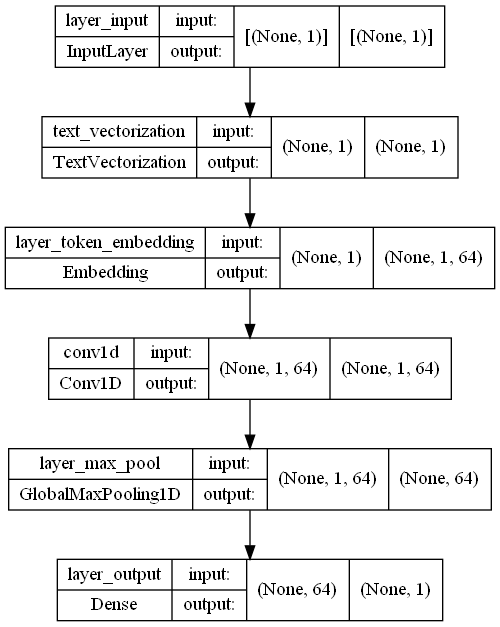

In [27]:
# Plot model_1
from tensorflow.keras.utils import plot_model # type: ignore
plot_model(model_1, show_shapes=True)

In [28]:
# import WandbCallback
from wandb.keras import WandbCallback

# Setup wandb init dan config
wb.init(project='ColorSkim',
        entity='jpao',
        name='model_1_Conv1D_embed',
        config={'epochs': 3,
                'n_layers': len(model_1.layers)})

# Fit model_1
hist_model_1 = model_1.fit(train_dataset,
                           epochs=wb.config.epochs,
                           validation_data=test_dataset,
                           callbacks=[WandbCallback()])

wandb: Currently logged in as: jpao. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/3
887/887 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9794

wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.


INFO:tensorflow:Assets written to: d:\ColorSkim\wandb\run-20220711_115920-o6q99kym\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ColorSkim\wandb\run-20220711_115920-o6q99kym\files\model-best\assets
wandb: Adding directory to artifact (d:\ColorSkim\wandb\run-20220711_115920-o6q99kym\files\model-best)... Done. 0.3s


887/887 [==============================] - 210s 225ms/step - loss: 0.1017 - accuracy: 0.9794 - val_loss: 0.0326 - val_accuracy: 0.9922 - _timestamp: 1657515766.0000 - _runtime: 205.0000
Epoch 2/3
887/887 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9952

INFO:tensorflow:Assets written to: d:\ColorSkim\wandb\run-20220711_115920-o6q99kym\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ColorSkim\wandb\run-20220711_115920-o6q99kym\files\model-best\assets
wandb: Adding directory to artifact (d:\ColorSkim\wandb\run-20220711_115920-o6q99kym\files\model-best)... Done. 0.1s


887/887 [==============================] - 149s 168ms/step - loss: 0.0191 - accuracy: 0.9952 - val_loss: 0.0300 - val_accuracy: 0.9925 - _timestamp: 1657515924.0000 - _runtime: 363.0000
Epoch 3/3
887/887 [==============================] - 129s 146ms/step - loss: 0.0163 - accuracy: 0.9956 - val_loss: 0.0303 - val_accuracy: 0.9926 - _timestamp: 1657516060.0000 - _runtime: 499.0000


In [29]:
# Evaluasi model_1
model_1.evaluate(test_dataset)

887/887 [==============================] - 45s 51ms/step - loss: 0.0303 - accuracy: 0.9926


[0.03030860796570778, 0.9925641417503357]

In [30]:
# Membuat prediksi berdasarkan model_1
model_1_pred_prob = model_1.predict(test_dataset)
model_1_pred_prob[:10]

array([[5.1793031e-05],
       [6.5180029e-05],
       [8.7126767e-07],
       [9.9771899e-01],
       [9.9969602e-01],
       [2.4920701e-06],
       [2.1196477e-04],
       [2.2293185e-03],
       [1.2963725e-04],
       [9.9663699e-01]], dtype=float32)

In [31]:
# Mengkonversi model_1_pred_prob ke dalam label
model_1_pred = tf.squeeze(tf.round(model_1_pred_prob))
model_1_pred

<tf.Tensor: shape=(28376,), dtype=float32, numpy=array([0., 0., 0., ..., 1., 0., 1.], dtype=float32)>

In [32]:
# Menghitung metriks dari model_1
model_1_metrik = hitung_metrik(target=test_label_encode,
                              prediksi=model_1_pred)
model_1_metrik

{'akurasi': 0.9925641387087679,
 'presisi': 0.9925790596107587,
 'recall': 0.9925641387087679,
 'f1-score': 0.9925584581306051}

## Model 2: Transfer Learning pretrained feature exraction menggunakan Universal Sentence Encoder (USE)

In [34]:
# Download pretrained USE
import tensorflow_hub as hub
tf_hub_embedding = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                  trainable=False,
                                  name='universal_sentence_encoder')

In [35]:
# Melakukan tes pretrained embedding pada contoh kata
kata_acak = random.choice(train_kata)
print(f'Kata acak:\n {kata_acak}')
kata_embed_pretrain = tf_hub_embedding([kata_acak])
print(f'\nKata setelah embed dengan USE:\n{kata_embed_pretrain[0][:30]}\n')
print(f'Panjang dari kata setelah embedding: {len(kata_embed_pretrain[0])}')

Kata acak:
 QUESTAR

Kata setelah embed dengan USE:
[ 0.00866413 -0.06154143  0.05114514  0.04181407  0.0199904   0.05046864
 -0.01953758 -0.05738599  0.06517273 -0.00517753  0.00351421  0.02564281
  0.02964722  0.06797459 -0.00300142  0.0053544  -0.00830155 -0.03211842
  0.04801427 -0.00119406 -0.00043531  0.01120288  0.04401749 -0.01213133
 -0.00378824  0.04055084 -0.01255467  0.02171156  0.05214996  0.01138981]

Panjang dari kata setelah embedding: 512


In [36]:
# Membuat model_2 menggunakan USE
inputs = layers.Input(shape=[], dtype=tf.string, name='layer_input')
layer_embed_pretrained = tf_hub_embedding(inputs)
x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(tf.expand_dims(layer_embed_pretrained, axis=-1))
x = layers.GlobalMaxPooling1D(name='layer_max_pooling')(x)
outputs = layers.Dense(1, activation='sigmoid', name='layer_output')(x)
model_2 = tf.keras.Model(inputs=inputs, outputs=outputs, name='model_2_Conv1D_USE_embed')

In [37]:
# Ringkasan model_2
model_2.summary()

Model: "model_2_Conv1D_USE_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_input (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 512, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, 512, 64)           384       
                                                                 
 layer_max_pooling (GlobalMa  (None, 64)               0         
 xPooling1D)                                                     
                                                                 
 layer_output (Dense)        (None, 1)    

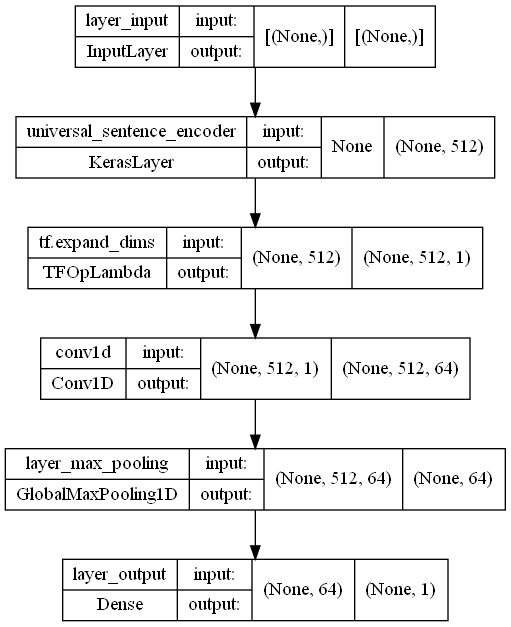

In [38]:
# Plot model_2
plot_model(model_2, show_shapes=True)

In [39]:
# Compile model_2
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [40]:
# Setup wandb init dan config
wb.init(project='ColorSkim',
        entity='jpao',
        name='model_2_Conv1D_USE_embed',
        config={'epochs': 3,
                'n_layers': len(model_2.layers)})

# Fit model_2
hist_model_2 = model_2.fit(train_dataset,
                           epochs=wb.config.epochs,
                           validation_data=test_dataset,
                           callbacks=[WandbCallback()])

accuracy,▁██
epoch,▁▅█
loss,█▁▁
val_accuracy,▁▆█
val_loss,█▁▂
GFLOPS,0.0
accuracy,0.99556
best_epoch,1
best_val_loss,0.03002
epoch,2
loss,0.01627


wandb: WARNING Unable to compute FLOPs for this model.


Epoch 1/3
887/887 [==============================] - 226s 246ms/step - loss: 0.6405 - accuracy: 0.6114 - val_loss: 0.5905 - val_accuracy: 0.8387 - _timestamp: 1657516765.0000 - _runtime: 297.0000
Epoch 2/3
887/887 [==============================] - 219s 247ms/step - loss: 0.5211 - accuracy: 0.8137 - val_loss: 0.4554 - val_accuracy: 0.8914 - _timestamp: 1657516982.0000 - _runtime: 514.0000
Epoch 3/3
887/887 [==============================] - 228s 257ms/step - loss: 0.4021 - accuracy: 0.8879 - val_loss: 0.3575 - val_accuracy: 0.9052 - _timestamp: 1657517211.0000 - _runtime: 743.0000


In [41]:
# Evaluate model_2
model_2.evaluate(test_dataset)

887/887 [==============================] - 67s 76ms/step - loss: 0.3575 - accuracy: 0.9052


[0.3574761152267456, 0.9051663279533386]

In [42]:
# Membuat prediksi dengan model_2
model_2_pred_prob = model_2.predict(test_dataset)
model_2_pred_prob[:10]

array([[0.16605161],
       [0.15431982],
       [0.20437935],
       [0.6168258 ],
       [0.8310257 ],
       [0.19871134],
       [0.21265136],
       [0.17426637],
       [0.1890059 ],
       [0.4124583 ]], dtype=float32)

In [43]:
# Mengkonversi model_2 menjadi label format
model_2_pred = tf.squeeze(tf.round(model_2_pred_prob))
model_2_pred

<tf.Tensor: shape=(28376,), dtype=float32, numpy=array([0., 0., 0., ..., 1., 0., 1.], dtype=float32)>

In [44]:
# Menghitung hasil metrik dari model_2
model_2_hasil = hitung_metrik(target=test_label_encode,
                              prediksi=model_2_pred)
model_2_hasil

{'akurasi': 0.9051663377502115,
 'presisi': 0.9052541793259783,
 'recall': 0.9051663377502115,
 'f1-score': 0.9045830735846138}

## Model 3: Menggunakan positional kata dan custom embed dan concatenate layer

In [45]:
# Test prediksi dengan model_1 (model_1_Conv1D_embed)
class_list = ['bukan_warna', 'warna']
article = 'PUMA XTG WOVEN PANTS PUMA BLACK-PUMA WHITE'
article_list = article.replace("-"," ").split()
model_test = tf.squeeze(tf.round(model_1.predict(article.replace("-"," ").split())))
for i in range(0, len(article_list)):
    print(f'Kata: {article_list[i]}\nPrediksi: {class_list[int(model_test[i])]}\n\n')

Kata: PUMA
Prediksi: bukan_warna


Kata: XTG
Prediksi: bukan_warna


Kata: WOVEN
Prediksi: bukan_warna


Kata: PANTS
Prediksi: bukan_warna


Kata: PUMA
Prediksi: bukan_warna


Kata: BLACK
Prediksi: warna


Kata: PUMA
Prediksi: bukan_warna


Kata: WHITE
Prediksi: warna




In [46]:
model_test

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 1.], dtype=float32)>